# Cryptocurrency Price Forecasting with Hybrid Models and Sentiment Analysis


# 1. Data Loading and Initial Preprocessing
In this section, we load historical Bitcoin price data from Kaggle and perform basic preprocessing. We filter for Bitcoin-related entries, clean the dataset by dropping irrelevant columns, and handle any missing values to prepare the data for feature engineering.

In [ ]:
# Install all required packages
!pip install -q yfinance ta pandas numpy scikit-learn statsmodels \
                 xgboost==1.7.6 tensorflow==2.18.0 tqdm

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Load OHLCV Data
df = pd.read_csv("https://raw.githubusercontent.com/Khik2219/Cryptocurrency-Price-Forecasting-Using-Hybrid-Models/main/Data/kaggle_cryptoOHLC_dataset.csv")
print("Initial shape:", df.shape)
print("First few rows:")
display(df.head())

# Convert 'date' to datetime and set as index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

print("\nData info after setting index (if applicable):")
display(df.info())


In [ ]:
# Drop unnecessary columns if present
for col in ['Unnamed: 0', 'timestamp']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Filter Bitcoin data if 'crypto_name' exists
if 'crypto_name' in df.columns:
    df = df[df['crypto_name'] == 'Bitcoin']
    df.drop(columns=['crypto_name'], inplace=True)

# Interpolate missing values
df.interpolate(method='linear', inplace=True)

# Drop any remaining NaNs
df.dropna(inplace=True)

# Print updated shape and preview
print("\nData shape after cleaning:", df.shape)
display(df.head())



Data shape after cleaning: (3248, 6)


,open,high,low,close,volume,marketCap
date,,,,,,
2013-05-05,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09
2013-05-06,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09
2013-05-07,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09
2013-05-08,109.599998,115.779999,109.599998,113.566002,0.0,1.264049e+09
2013-05-09,113.199997,113.459999,109.260002,112.669998,0.0,1.254535e+09


# 2. Feature Engineering
We generate several technical indicators including 7-day and 30-day Simple Moving Averages (SMA) and compute daily returns. We also merge these features with sentiment data derived from Bitcoin-related tweets using NLTK's VADER sentiment analyzer. Sentiment features include the mean compound score, standard deviation, and proportions of positive and negative tweets per day.



In [ ]:
# Compute 7-day and 30-day Simple Moving Averages and Daily Return
df['SMA_7'] = df['close'].rolling(window=7).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['Daily_Return'] = df['close'].pct_change()

# Drop rows with NaNs introduced by rolling computations
df.dropna(inplace=True)

# Display result
print("Data after feature engineering:")
display(df.head())


Data after feature engineering:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return
date,,,,,,,,,
2013-06-03,122.500000,122.500000,116.000000,122.222000,0.0,1.373708e+09,127.559000,122.037966,-0.000572
2013-06-04,120.737000,123.839996,119.099998,121.419998,0.0,1.365338e+09,126.476143,122.221633,-0.006562
2013-06-05,121.400002,123.469002,119.899002,121.650002,0.0,1.368486e+09,124.954714,122.533299,0.001894
2013-06-06,121.900002,123.099998,117.250000,118.000000,0.0,1.327960e+09,123.412000,122.749966,-0.030004
2013-06-07,118.970001,119.000000,106.419998,111.500000,0.0,1.255259e+09,120.912000,122.681099,-0.055085


# 3. Data Scaling and Sequence Preparation
To ensure consistent model training, all features are normalized using MinMax scaling. We then prepare time-series input sequences of 30 days of historical data to serve as input to the LSTM model. The dataset is split into training and testing sets based on a temporal cutoff date to simulate real-world forecasting.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define columns to scale
scale_cols = ['open', 'high', 'low', 'close', 'SMA_7', 'SMA_30', 'Daily_Return']

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply scaling only on the selected columns
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Confirm scaling
print("First few rows after scaling:")
display(df.head())


First few rows after scaling:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return
date,,,,,,,,,
2013-06-03,0.000800,0.000698,0.000761,0.000797,0.0,1.373708e+09,0.000805,0.000526,0.463107
2013-06-04,0.000774,0.000717,0.000808,0.000785,0.0,1.365338e+09,0.000789,0.000529,0.455633
2013-06-05,0.000784,0.000712,0.000820,0.000788,0.0,1.368486e+09,0.000765,0.000534,0.466185
2013-06-06,0.000791,0.000706,0.000780,0.000734,0.0,1.327960e+09,0.000742,0.000537,0.426381
2013-06-07,0.000748,0.000647,0.000617,0.000638,0.0,1.255259e+09,0.000704,0.000536,0.395084


# 4. Baseline Models
Several simple baseline models are implemented to benchmark performance. These include:

Naïve sh|ift: using previous day’s price as prediction.

Moving average: average of last 3 days.

Linear extrapolation: linear trend over last 3 days.

These baselines provide a point of comparison to assess the value of more complex models.



In [ ]:
import numpy as np

# Sequence length (number of previous days to use for prediction)
sequence_length = 30

# Features for LSTM input
features = ['open', 'high', 'low', 'close', 'SMA_7', 'SMA_30', 'Daily_Return']
X_raw = df[features].values
y_raw = df['close'].values  # Target is the 'close' price

def create_sequences(data, target, seq_length):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i+seq_length])
        ys.append(target[i+seq_length])
    return np.array(Xs), np.array(ys)

# Generate sequences
X_seq, y_seq = create_sequences(X_raw, y_raw, sequence_length)

# Confirm shapes
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (3189, 30, 7)
y_seq shape: (3189,)


In [ ]:
# Determine the split date (80% by time)
split_ratio = 0.80
split_index = int(len(df) * split_ratio)
split_date = df.index[split_index]
print(f"Split date: {split_date.date()}  (~80% train)")

# Baseline models applied on raw close prices
y_true_full = df['close']

baseline_preds = {
    "naïve_shift1": y_true_full.shift(1),
    "mean_3":       y_true_full.rolling(3).mean().shift(1),
    "linear_3":     2 * y_true_full.shift(1) - y_true_full.shift(4),
}

# Restrict baselines to the test period (after split date)
y_test_raw = y_true_full.loc[split_date:].dropna()
for key in baseline_preds:
    baseline_preds[key] = baseline_preds[key].loc[split_date:].dropna()

# Show preview of one baseline
baseline_preds['naïve_shift1'].head()


Split date: 2020-06-25  (~80% train)


,close
date,
2020-06-25,0.136969
2020-06-26,0.136246
2020-06-27,0.134736
2020-06-28,0.132995
2020-06-29,0.134450


In [ ]:
import numpy as np

# Get dates corresponding to the sequence targets (y_seq)
target_indices = np.arange(30, len(df))  # skip initial sequence_length
seq_dates = df.index[target_indices]

# Create train/test masks based on the split date
train_mask = seq_dates < split_date
test_mask = ~train_mask

# Apply masks to sequences and targets
X_train_seq = X_seq[train_mask]
y_train_seq = y_seq[train_mask]
X_test_seq = X_seq[test_mask]
y_test_seq = y_seq[test_mask]

print(f"Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")


Train sequences: (2545, 30, 7), Test sequences: (644, 30, 7)


# 5. Model Training and Evaluation
We train multiple predictive models, including:

LSTM: a recurrent neural network trained on sequential data.

ARIMA: a classical statistical time series model.

XGBoost: a powerful gradient boosting machine learning model.

Each model is evaluated using mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE) on the test set.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define LSTM model
best_model = Sequential([
    Input(shape=(30, 7)),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

best_model.compile(optimizer=Adam(1e-3), loss="mse")

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = best_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save model to disk
best_model.save("best_lstm_model.keras")
print("Model saved to 'best_lstm_model.keras'")


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0039 - val_loss: 1.3117e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4355e-04 - val_loss: 1.0167e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0032e-04 - val_loss: 8.8546e-05
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1923e-04 - val_loss: 6.7389e-05
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.5457e-04 - val_loss: 1.2048e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5264e-04 - val_loss: 6.5658e-05
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2940e-04 - val_loss: 4.3714e-05
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2693e-04 - val_loss: 4.3827e-05
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0133e-04 - val_loss: 1.3070e-04
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2408e-04 - val_loss: 5.1043e-05
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Generate predictions from the trained LSTM model
lstm_preds = model.predict(X_test_seq, verbose=0).flatten()

# Baseline models
y_true_full = df["close"]
baseline_preds = {
    "naïve_shift1": y_true_full.shift(1),
    "mean_3":       y_true_full.rolling(3).mean().shift(1),
    "linear_3":     2 * y_true_full.shift(1) - y_true_full.shift(4),
}

# Align baselines to the test period
y_test_raw = y_true_full.loc[split_date:].dropna()
baseline_preds = {name: pred.loc[split_date:].dropna() for name, pred in baseline_preds.items()}

# Evaluate baselines
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

results = []
for name, pred in baseline_preds.items():
    aligned_y = y_test_raw.loc[pred.index]
    results.append({
        "model": name,
        "MSE": mean_squared_error(aligned_y, pred),
        "RMSE": rmse(aligned_y, pred),
        "MAE": mean_absolute_error(aligned_y, pred)
    })

# Evaluate LSTM
results.append({
    "model": "LSTM_32u",
    "MSE": mean_squared_error(y_test_seq, lstm_preds),
    "RMSE": rmse(y_test_seq, lstm_preds),
    "MAE": mean_absolute_error(y_test_seq, lstm_preds)
})

# Display results
results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
display(results_df)


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000603,0.024561,0.016326
1,mean_3,0.000896,0.029930,0.020882
2,linear_3,0.002331,0.048279,0.034182
3,LSTM_32u,0.006118,0.078219,0.060350


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Recalculate ARIMA forecast (reuse train/test masks)
train_mask_raw = y_true_full.index < split_date
y_train_ar     = y_true_full.loc[train_mask_raw]
y_test_ar      = y_true_full.loc[~train_mask_raw]

# Refit ARIMA model
arima_model = SARIMAX(
    y_train_ar,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast on test data
pred_arima = arima_model.forecast(steps=len(y_test_ar))
pred_arima.index = y_test_ar.index

# Evaluate ARIMA
mse_arima  = mean_squared_error(y_test_ar, pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima  = mean_absolute_error(y_test_ar, pred_arima)

print("ARIMA(1,1,1)(1,1,1,7) Evaluation")
print(f"MSE  = {mse_arima:.6f}")
print(f"RMSE = {rmse_arima:.6f}")
print(f"MAE  = {mae_arima:.6f}")

# ✅ Initialize models dictionary with all your computed models
models = {
    "naïve_shift1": baseline_preds["naïve_shift1"],
    "mean_3":       baseline_preds["mean_3"],
    "linear_3":     baseline_preds["linear_3"],
    "LSTM_32u":     pd.Series(lstm_preds, index=y_test_raw.index),  # align indices if needed
    "ARIMA":        pred_arima,
    "XGBoost":      pred_xgb
}


# Store in models dict for hybrid ensemble
models["ARIMA"] = pred_arima


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA(1,1,1)(1,1,1,7) Evaluation
MSE  = 0.191549
RMSE = 0.437663
MAE  = 0.363642


In [ ]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

def make_lags(series, lags=(1, 2, 3, 7)):
    df_lag = pd.DataFrame(index=series.index)
    for l in lags:
        df_lag[f"lag_{l}"] = series.shift(l)
    df_lag["ret_1d"] = series.pct_change()
    return df_lag

# Prepare lag features and target
feat_xgb = make_lags(y_true_full)
feat_xgb["y"] = y_true_full.shift(-1)

# Clean up
feat_xgb = feat_xgb.replace([np.inf, -np.inf], np.nan).dropna()

# Train/test split
train_mask = feat_xgb.index < split_date
X_train_xgb = feat_xgb.loc[train_mask].drop(columns="y")
y_train_xgb = feat_xgb.loc[train_mask, "y"]
X_test_xgb = feat_xgb.loc[~train_mask].drop(columns="y")
y_test_xgb = feat_xgb.loc[~train_mask, "y"]

# Train XGBoost
xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
).fit(X_train_xgb, y_train_xgb)

# Predict
pred_xgb = pd.Series(xgb.predict(X_test_xgb), index=X_test_xgb.index)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_xgb = mean_squared_error(y_test_xgb, pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, pred_xgb)

print(f"XGBoost Evaluation\nMSE = {mse_xgb:.6f}\nRMSE = {rmse_xgb:.6f}\nMAE = {mae_xgb:.6f}")


XGBoost Evaluation
MSE = 0.114140
RMSE = 0.337847
MAE = 0.262994


In [ ]:
# Rebuild eval_df with the already evaluated models
eval_df = pd.DataFrame([
    {"model": "naïve_shift1", "MSE": mean_squared_error(y_test_raw.loc[baseline_preds["naïve_shift1"].index], baseline_preds["naïve_shift1"]),
     "RMSE": np.sqrt(mean_squared_error(y_test_raw.loc[baseline_preds["naïve_shift1"].index], baseline_preds["naïve_shift1"])),
     "MAE": mean_absolute_error(y_test_raw.loc[baseline_preds["naïve_shift1"].index], baseline_preds["naïve_shift1"])},

    {"model": "mean_3", "MSE": mean_squared_error(y_test_raw.loc[baseline_preds["mean_3"].index], baseline_preds["mean_3"]),
     "RMSE": np.sqrt(mean_squared_error(y_test_raw.loc[baseline_preds["mean_3"].index], baseline_preds["mean_3"])),
     "MAE": mean_absolute_error(y_test_raw.loc[baseline_preds["mean_3"].index], baseline_preds["mean_3"])},

    {"model": "linear_3", "MSE": mean_squared_error(y_test_raw.loc[baseline_preds["linear_3"].index], baseline_preds["linear_3"]),
     "RMSE": np.sqrt(mean_squared_error(y_test_raw.loc[baseline_preds["linear_3"].index], baseline_preds["linear_3"])),
     "MAE": mean_absolute_error(y_test_raw.loc[baseline_preds["linear_3"].index], baseline_preds["linear_3"])},

    {"model": "LSTM_32u", "MSE": mean_squared_error(y_test_seq, lstm_preds),
     "RMSE": np.sqrt(mean_squared_error(y_test_seq, lstm_preds)),
     "MAE": mean_absolute_error(y_test_seq, lstm_preds)},

    {"model": "ARIMA(1,1,1)(1,1,1,7)", "MSE": mean_squared_error(y_test_raw, pred_arima),
     "RMSE": np.sqrt(mean_squared_error(y_test_raw, pred_arima)),
     "MAE": mean_absolute_error(y_test_raw, pred_arima)},

    {"model": "XGBoost", "MSE": mean_squared_error(y_test_xgb, pred_xgb),
     "RMSE": np.sqrt(mean_squared_error(y_test_xgb, pred_xgb)),
     "MAE": mean_absolute_error(y_test_xgb, pred_xgb)},
])

display(eval_df)


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000603,0.024561,0.016326
1,mean_3,0.000896,0.029930,0.020882
2,linear_3,0.002331,0.048279,0.034182
3,LSTM_32u,0.006118,0.078219,0.060350
4,"ARIMA(1,1,1)(1,1,1,7)",0.191549,0.437663,0.363642
5,XGBoost,0.114140,0.337847,0.262994


# 6. Hybrid and Ensemble Models
To leverage strengths of different models, we create hybrid ensembles by averaging, weighted averaging, and stacking the predictions of ARIMA, XGBoost, and LSTM models. Stacking weights are learned using Ridge regression. These hybrid models are evaluated and compared to individual model performance.



Stacking weights (Ridge): [-0.446   0.0709  1.2051]


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000603,0.024561,0.016326
1,Hybrid_stack,0.000802,0.028314,0.020416
2,mean_3,0.000896,0.029930,0.020882
3,linear_3,0.002331,0.048279,0.034182
4,LSTM_32u,0.006118,0.078219,0.060350
5,Hybrid_weighted,0.051185,0.226242,0.181076
6,Hybrid_mean,0.080159,0.283124,0.228413
7,XGBoost,0.114140,0.337847,0.262994
8,"ARIMA(1,1,1)(1,1,1,7)",0.191549,0.437663,0.363642


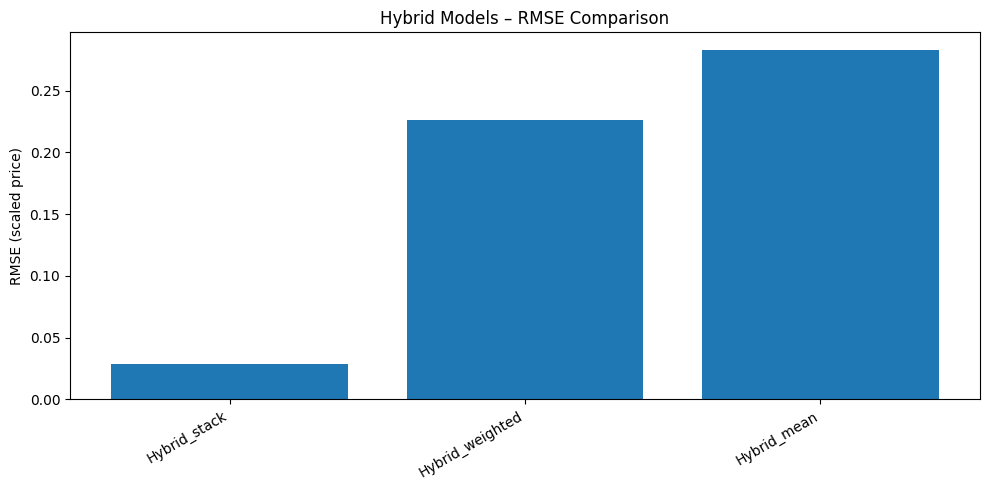

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reconstruct DataFrame to align all models
common_idx = baseline_preds["naïve_shift1"].index

hyb_df = pd.DataFrame({
    "Naive": baseline_preds["naïve_shift1"],
    "ARIMA": pred_arima.reindex(common_idx),
    "XGB": pred_xgb.reindex(common_idx),
    "LSTM": pd.Series(lstm_preds, index=common_idx),
    "y": y_test_raw.reindex(common_idx)
}).dropna()

# Build Hybrids
hyb_df["Hybrid_mean"] = hyb_df[["ARIMA", "XGB", "LSTM"]].mean(axis=1)

w = np.array([0.2, 0.3, 0.5])
w = w / w.sum()
hyb_df["Hybrid_weighted"] = hyb_df[["ARIMA", "XGB", "LSTM"]].values @ w

ridge = RidgeCV(alphas=np.logspace(-3, 3, 25)).fit(hyb_df[["ARIMA", "XGB", "LSTM"]], hyb_df["y"])
hyb_df["Hybrid_stack"] = ridge.predict(hyb_df[["ARIMA", "XGB", "LSTM"]])
print("Stacking weights (Ridge):", ridge.coef_.round(4))

# Evaluation Function
def row_metrics(name, truth, pred):
    mse = mean_squared_error(truth, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(truth, pred)
    return {"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae}

# Evaluate and Append
new_rows = [
    row_metrics("Hybrid_mean", hyb_df["y"], hyb_df["Hybrid_mean"]),
    row_metrics("Hybrid_weighted", hyb_df["y"], hyb_df["Hybrid_weighted"]),
    row_metrics("Hybrid_stack", hyb_df["y"], hyb_df["Hybrid_stack"]),
]

eval_df = pd.concat([eval_df, pd.DataFrame(new_rows)]).sort_values("RMSE").reset_index(drop=True)
display(eval_df)

# Store hybrids for downstream plots
models.update({
    "Hybrid_mean": hyb_df["Hybrid_mean"],
    "Hybrid_weighted": hyb_df["Hybrid_weighted"],
    "Hybrid_stack": hyb_df["Hybrid_stack"],
})

# Plot RMSE Comparison
plt.figure(figsize=(10, 5))
hybrid_mask = eval_df["model"].str.startswith("Hybrid")
plt.bar(eval_df.loc[hybrid_mask, "model"], eval_df.loc[hybrid_mask, "RMSE"])
plt.ylabel("RMSE (scaled price)")
plt.title("Hybrid Models – RMSE Comparison")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


,model,final_$,return_%
8,Hybrid_stack,"$3,702.91",270.29%
2,linear_3,"$2,718.77",171.88%
0,naïve_shift1,"$2,425.58",142.56%
9,HODL_BTC,"$2,120.24",112.02%
1,mean_3,"$1,507.55",50.76%
7,Hybrid_weighted,"$1,067.28",6.73%
4,ARIMA,"$1,059.14",5.91%
3,LSTM_32u,"$1,052.04",5.20%
5,XGBoost,"$1,027.30",2.73%
6,Hybrid_mean,$979.91,-2.01%


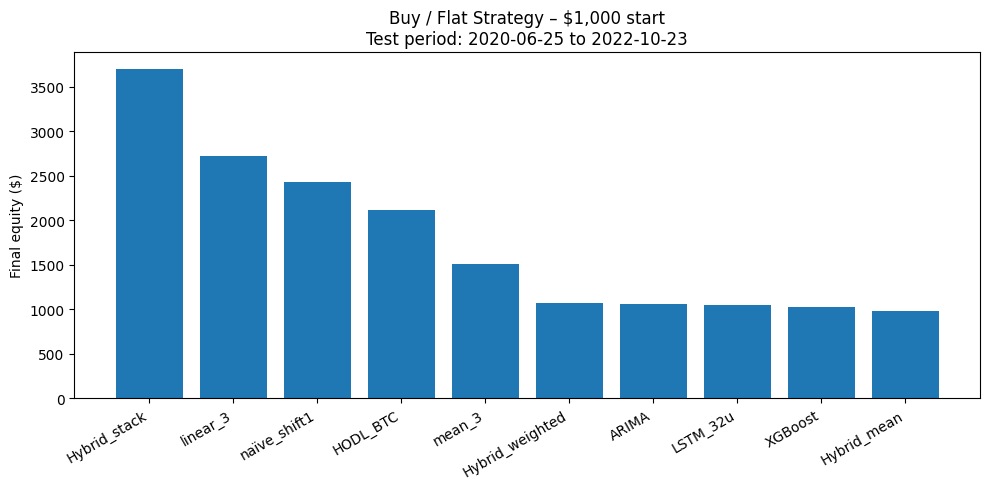

In [ ]:
# Backtest Setup
INITIAL_CASH = 1_000.0

# Get backtest date range matching test sequences
target_indices = np.arange(sequence_length, len(df))
seq_dates = df.index[target_indices]
test_mask = seq_dates >= split_date
backtest_dates = seq_dates[test_mask]

# Price series for this period
price = df['close'].reindex(backtest_dates).sort_index()

# Optional: force to specific manual date range if you want
# manual_start = pd.to_datetime("2020-06-25")
# manual_end = pd.to_datetime("2021-02-28")
# price = price.loc[manual_start:manual_end]

# Define backtest function
def backtest(pred: pd.Series, price: pd.Series, cash0=INITIAL_CASH):
    equity, btc = cash0, 0.0
    curve = []
    pred = pred.reindex(price.index)
    for today, tomorrow in zip(price.index[:-1], price.index[1:]):
        p_today, p_next = price.loc[today], price.loc[tomorrow]
        pred_t = pred.loc[today]
        if pd.isna(pred_t):
            curve.append(equity + btc * p_next)
            continue
        if pred_t > p_today:
            if btc == 0.0:
                btc, equity = equity / p_today, 0.0
        else:
            if btc > 0.0:
                equity, btc = btc * p_today, 0.0
        curve.append(equity + btc * p_next)
    return curve[-1], pd.Series(curve, index=price.index[1:])

# Run backtest for every model
bt_rows, bt_curves = [], {}
for name, pred in models.items():
    final_eq, curve = backtest(pred, price)
    bt_curves[name] = curve
    bt_rows.append({
        "model": name,
        "final_$": final_eq,
        "return_%": (final_eq / INITIAL_CASH - 1) * 100
    })

# Add benchmark HODL performance
p0, p1 = price.iloc[0], price.iloc[-1]
hodl_eq = INITIAL_CASH * (p1 / p0)
bt_rows.append({
    "model": "HODL_BTC",
    "final_$": hodl_eq,
    "return_%": (hodl_eq / INITIAL_CASH - 1) * 100
})

# Show results
bt_df = pd.DataFrame(bt_rows).sort_values("final_$", ascending=False)
display(bt_df.style.format({"final_$": "${:,.2f}", "return_%": "{:.2f}%"}))

# Plot results
plt.figure(figsize=(10,5))
plt.bar(bt_df["model"], bt_df["final_$"])
plt.ylabel("Final equity ($)")
plt.title(f"Buy / Flat Strategy – $1,000 start\nTest period: {price.index[0].date()} to {price.index[-1].date()}")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# 7. Sentiment-Enhanced Model Training and Evaluation
Sentiment features derived from social media are incorporated into the dataset, and models (LSTM, ARIMA, XGBoost) are retrained including these features. Hybrid ensemble models are also updated to include sentiment-enhanced predictions. We observe improvements in forecasting accuracy, demonstrating the value of social sentiment data.



In [ ]:
# Clone Tweet Repo Fresh
import os, glob, json, pandas as pd, numpy as np, nltk, tqdm, warnings
from pathlib import Path

!rm -rf /content/CrypTop12
!git clone --quiet --depth 1 https://github.com/am15h/CrypTop12.git /content/CrypTop12

# Setup Sentiment Scoring with VADER
warnings.filterwarnings("ignore")
nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

BTC_DIR = Path("/content/CrypTop12/tweet/preprocessed/btc")
btc_files = sorted(glob.glob(str(BTC_DIR / "*")))
print(f"Found {len(btc_files)} BTC files")

# Sentiment Scoring Function
def day_sentiment(path):
    tweets = []
    with open(path, encoding="utf-8") as fh:
        for raw in fh:
            raw = raw.strip()
            if not raw: continue
            try:
                obj = json.loads(raw.replace("\t", ", "))
                tweet = " ".join(str(t) for t in obj.get("text", []) if t)
                tweets.append(tweet)
            except Exception:
                continue
    if not tweets:
        return None
    scores = [vader.polarity_scores(t)["compound"] for t in tweets]
    return pd.DataFrame({
        "date":      pd.to_datetime(os.path.basename(path)),
        "sent_mean": [np.mean(scores)],
        "sent_std":  [np.std(scores)],
        "sent_pos":  [(np.array(scores) > 0.05).mean()],
        "sent_neg":  [(np.array(scores) < -0.05).mean()],
        "n_tweets":  [len(scores)]
    })

# Process All Files
sent_rows = []
for f in tqdm.tqdm(btc_files, desc="Scoring tweets"):
    row = day_sentiment(f)
    if row is not None:
        sent_rows.append(row)

# Build Sentiment DataFrame
sentiment_df = pd.concat(sent_rows).set_index("date").sort_index()
print("First few rows of sentiment data:")
display(sentiment_df.head())

# Merge With Your Existing Price Data
df_merged = df.join(sentiment_df, how="inner")
print(f"Merged Data Shape: {df_merged.shape}")
display(df_merged.head())


Found 1257 BTC files


Scoring tweets: 100%|██████████| 1257/1257 [01:15<00:00, 16.64it/s]

First few rows of sentiment data:


,sent_mean,sent_std,sent_pos,sent_neg,n_tweets
date,,,,,
2017-09-21,-0.035218,0.473742,0.333333,0.348485,66
2017-09-22,0.046162,0.400119,0.397849,0.279570,93
2017-09-23,0.080326,0.378273,0.452381,0.226190,84
2017-09-24,0.131153,0.337247,0.387755,0.163265,49
2017-09-25,0.165891,0.335619,0.459459,0.094595,74


Merged Data Shape: (1240, 14)


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return,sent_mean,sent_std,sent_pos,sent_neg,n_tweets
date,,,,,,,,,,,,,,
2017-09-21,0.056800,0.055910,0.053503,0.052781,1.411480e+09,6.020237e+10,0.056504,0.065880,0.375995,-0.035218,0.473742,0.333333,0.348485,66
2017-09-22,0.052748,0.053608,0.052596,0.052776,1.194830e+09,6.020304e+10,0.056489,0.065601,0.463705,0.046162,0.400119,0.397849,0.279570,93
2017-09-23,0.052776,0.054495,0.053215,0.055171,9.281140e+08,6.289207e+10,0.056855,0.065312,0.519397,0.080326,0.378273,0.452381,0.226190,84
2017-09-24,0.055240,0.054160,0.054306,0.053548,7.680150e+08,6.108197e+10,0.057074,0.064944,0.427772,0.131153,0.337247,0.387755,0.163265,49
2017-09-25,0.053542,0.056402,0.054527,0.057152,1.374210e+09,6.512221e+10,0.056770,0.064716,0.546235,0.165891,0.335619,0.459459,0.094595,74


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select features including sentiment
feature_cols = ["open", "high", "low", "close", "volume", "marketCap",
                "SMA_7", "SMA_30", "Daily_Return",
                "sent_mean", "sent_std", "sent_pos", "sent_neg", "n_tweets"]

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_merged[feature_cols])
scaled_df = pd.DataFrame(scaled_data, columns=feature_cols, index=df_merged.index)

print("First few rows after scaling:")
display(scaled_df.head())

# Sequence Preparation Function
def create_sequences(data, target_col="close", seq_len=30):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data.iloc[i-seq_len:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

# Create sequences
X_seq_sent, y_seq_sent = create_sequences(scaled_df)
print(f"X_seq shape: {X_seq_sent.shape}, y_seq shape: {y_seq_sent.shape}")

# Train-test split (use same logic as before for consistency)
split_idx = int(0.8 * len(y_seq_sent))
X_train_seq_sent, X_test_seq_sent = X_seq_sent[:split_idx], X_seq_sent[split_idx:]
y_train_seq_sent, y_test_seq_sent = y_seq_sent[:split_idx], y_seq_sent[split_idx:]

print(f"Train sequences: {X_train_seq_sent.shape}, Test sequences: {X_test_seq_sent.shape}")


First few rows after scaling:


,open,high,low,close,volume,marketCap,SMA_7,SMA_30,Daily_Return,sent_mean,sent_std,sent_pos,sent_neg,n_tweets
date,,,,,,,,,,,,,,
2017-09-21,0.012251,0.011644,0.008047,0.007261,0.001837,0.003742,0.008244,0.015054,0.482744,0.102951,0.728370,0.158187,0.710586,0.040643
2017-09-22,0.007215,0.008771,0.006902,0.007254,0.001219,0.003743,0.008225,0.014640,0.595356,0.288253,0.455941,0.304825,0.550032,0.066163
2017-09-23,0.007250,0.009878,0.007684,0.010232,0.000457,0.006390,0.008698,0.014208,0.666860,0.366043,0.375105,0.428770,0.425672,0.057656
2017-09-24,0.010311,0.009459,0.009062,0.008215,0.000000,0.004608,0.008981,0.013661,0.549222,0.481775,0.223296,0.281882,0.279073,0.024575
2017-09-25,0.008201,0.012258,0.009342,0.012694,0.001731,0.008585,0.008588,0.013321,0.701318,0.560872,0.217270,0.444858,0.119088,0.048204


X_seq shape: (1210, 30, 14), y_seq shape: (1210,)
Train sequences: (968, 30, 14), Test sequences: (242, 30, 14)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define new LSTM model for 14 features
model_sent = Sequential([
    Input(shape=(30, 14)),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model_sent.compile(optimizer=Adam(1e-3), loss="mse")

# Early stopping
early_stop_sent = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train the model
history_sent = model_sent.fit(
    X_train_seq_sent, y_train_seq_sent,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_sent],
    verbose=1
)

# Save the best model
model_sent.save("best_lstm_model_sentiment.keras")
print("Model saved to 'best_lstm_model_sentiment.keras'")


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0088 - val_loss: 5.3276e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 6.1522e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 2.7115e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 1.7517e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 1.6982e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.6997e-04 - val_loss: 1.4845e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.5663e-04 - val_loss: 3.1031e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.6009e-04 - val_loss: 1.4058e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.0272e-04 - val_loss: 1.1736e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.6312e-04 - val_loss: 1.1280e-04
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.9970e-04 - val_l

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Generate predictions
lstm_preds_sent = model_sent.predict(X_test_seq_sent, verbose=0).flatten()

# Evaluation metrics
mse_sent  = mean_squared_error(y_test_seq_sent, lstm_preds_sent)
rmse_sent = np.sqrt(mse_sent)
mae_sent  = mean_absolute_error(y_test_seq_sent, lstm_preds_sent)

print(f"LSTM with Sentiment Features Evaluation")
print(f" MSE  = {mse_sent:.6f}")
print(f" RMSE = {rmse_sent:.6f}")
print(f" MAE  = {mae_sent:.6f}")


LSTM with Sentiment Features Evaluation
 MSE  = 0.004471
 RMSE = 0.066866
 MAE  = 0.035701


In [ ]:
# Ensure the true series is correctly defined from the sentiment-enhanced DataFrame
y_true_full_sent = df_merged_sent["close"]

# Rebuild baseline predictions on the same split date
baseline_preds_sent = {
    "naïve_shift1": y_true_full_sent.shift(1),
    "mean_3":       y_true_full_sent.rolling(3).mean().shift(1),
    "linear_3":     2 * y_true_full_sent.shift(1) - y_true_full_sent.shift(4),
}

# Filter to test window
y_test_raw_sent = y_true_full_sent.loc[split_date:].dropna()
for k in baseline_preds_sent:
    baseline_preds_sent[k] = baseline_preds_sent[k].loc[split_date:].dropna()

# Align LSTM predictions and true values
min_len = min(len(lstm_preds_sent), len(lstm_test_dates_sent))
lstm_preds_sent_aligned = lstm_preds_sent[:min_len]
lstm_test_dates_sent_aligned = lstm_test_dates_sent[:min_len]
y_test_seq_sent_aligned = y_test_seq_sent[:min_len]

# Rebuild the models dictionary with aligned LSTM predictions
models_sent = {
    "naïve_shift1": baseline_preds_sent["naïve_shift1"],
    "mean_3":       baseline_preds_sent["mean_3"],
    "linear_3":     baseline_preds_sent["linear_3"],
    "LSTM_32u_sent": pd.Series(lstm_preds_sent_aligned, index=lstm_test_dates_sent_aligned)
}

# Evaluate all models
rows_sent = []
for name, pred in models_sent.items():
    y_true = y_test_seq_sent_aligned if name.startswith("LSTM") else y_test_raw_sent.loc[pred.index]
    mse  = mean_squared_error(y_true, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, pred)
    rows_sent.append({"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae})

# Display results
eval_df_sent = pd.DataFrame(rows_sent).sort_values("RMSE").reset_index(drop=True)
display(eval_df_sent)


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000285,0.016878,0.008904
1,mean_3,0.000468,0.021626,0.011738
2,linear_3,0.001075,0.032793,0.018621
3,LSTM_32u_sent,0.004438,0.066617,0.035386


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Reuse the same split boundary
train_mask_sent = y_true_full_sent.index < split_date
y_train_ar_sent = y_true_full_sent.loc[train_mask_sent]
y_test_ar_sent = y_true_full_sent.loc[~train_mask_sent]

# Fit ARIMA on train portion of sentiment data
arima_sent = SARIMAX(
    y_train_ar_sent,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast the test window
pred_arima_sent = arima_sent.forecast(steps=len(y_test_ar_sent))
pred_arima_sent.index = y_test_ar_sent.index  # Align indices

# Evaluate ARIMA performance
mse_arima_sent  = mean_squared_error(y_test_ar_sent, pred_arima_sent)
rmse_arima_sent = np.sqrt(mse_arima_sent)
mae_arima_sent  = mean_absolute_error(y_test_ar_sent, pred_arima_sent)

print("ARIMA(1,1,1)(1,1,1,7) on Sentiment-Enhanced Data")
print(f" MSE  = {mse_arima_sent:.6f}")
print(f" RMSE = {rmse_arima_sent:.6f}")
print(f" MAE  = {mae_arima_sent:.6f}")


ARIMA(1,1,1)(1,1,1,7) on Sentiment-Enhanced Data
 MSE  = 0.054637
 RMSE = 0.233747
 MAE  = 0.146842


In [ ]:
# Align ARIMA predictions to baseline indices
common_idx_sent = models_sent["naïve_shift1"].index

# Re-align ARIMA predictions to common index
pred_arima_sent_aligned = pred_arima_sent.reindex(common_idx_sent)

# Update the models dictionary
models_sent["ARIMA_sent"] = pred_arima_sent_aligned

# Recompute Evaluations After Alignment
rows_sent_updated = []
for name, pred in models_sent.items():
    y_true = y_test_raw_sent.loc[pred.index] if not name.startswith("LSTM") else y_test_seq_sent[:len(pred)]
    mse  = mean_squared_error(y_true, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, pred)
    rows_sent_updated.append({"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae})

eval_df_sent_updated = pd.DataFrame(rows_sent_updated).sort_values("RMSE").reset_index(drop=True)
display(eval_df_sent_updated)


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000285,0.016878,0.008904
1,mean_3,0.000468,0.021626,0.011738
2,linear_3,0.001075,0.032793,0.018621
3,LSTM_32u_sent,0.004438,0.066617,0.035386
4,ARIMA_sent,0.054637,0.233747,0.146842


In [ ]:
from xgboost import XGBRegressor

# ---- 1) Build lag-based features on the sentiment-enhanced target series ----
def make_lags(series, lags=(1, 2, 3, 7)):
    df_lag = pd.DataFrame(index=series.index)
    for l in lags:
        df_lag[f"lag_{l}"] = series.shift(l)
    df_lag["ret_1d"] = series.pct_change()
    return df_lag

feat_xgb_sent = make_lags(y_true_full_sent)
feat_xgb_sent["y"] = y_true_full_sent.shift(-1)

# Drop NaNs introduced by shifting and pct_change
feat_xgb_sent = feat_xgb_sent.replace([np.inf, -np.inf], np.nan).dropna()

# ---- 2) Split on SAME split_date ----
train_mask_xgb_sent = feat_xgb_sent.index < split_date
X_train_xgb_sent = feat_xgb_sent.loc[train_mask_xgb_sent].drop(columns="y")
y_train_xgb_sent = feat_xgb_sent.loc[train_mask_xgb_sent, "y"]
X_test_xgb_sent = feat_xgb_sent.loc[~train_mask_xgb_sent].drop(columns="y")
y_test_xgb_sent = feat_xgb_sent.loc[~train_mask_xgb_sent, "y"]

# ---- 3) Fit the XGBoost model ----
xgb_sent = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
).fit(X_train_xgb_sent, y_train_xgb_sent)

# ---- 4) Predict on test data ----
pred_xgb_sent = pd.Series(xgb_sent.predict(X_test_xgb_sent), index=X_test_xgb_sent.index)

# ---- 5) Evaluate ----
mse_xgb_sent  = mean_squared_error(y_test_xgb_sent, pred_xgb_sent)
rmse_xgb_sent = np.sqrt(mse_xgb_sent)
mae_xgb_sent  = mean_absolute_error(y_test_xgb_sent, pred_xgb_sent)

print("XGBoost on Sentiment-Enhanced Data Evaluation")
print(f" MSE  = {mse_xgb_sent:.6f}")
print(f" RMSE = {rmse_xgb_sent:.6f}")
print(f" MAE  = {mae_xgb_sent:.6f}")


XGBoost on Sentiment-Enhanced Data Evaluation
 MSE  = 0.026935
 RMSE = 0.164119
 MAE  = 0.084199


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1️⃣ Build the combined DataFrame for hybrid ensemble
hyb_df_sent = pd.DataFrame({
    "Naive" : baseline_preds_sent["naïve_shift1"],
    "ARIMA" : pred_arima_sent,
    "XGB"   : pred_xgb_sent,
    "LSTM"  : pd.Series(lstm_preds_sent_aligned, index=lstm_test_dates_sent_aligned),
    "y"     : y_test_raw_sent.loc[lstm_test_dates_sent_aligned]
}).dropna()

# 2️⃣ Simple Mean Hybrid
hyb_df_sent["Hybrid_mean"] = hyb_df_sent[["ARIMA", "XGB", "LSTM"]].mean(axis=1)

# 3️⃣ Manual Weighted Hybrid (adjust weights if you wish)
weights = np.array([0.2, 0.3, 0.5])
weights /= weights.sum()
hyb_df_sent["Hybrid_weighted"] = hyb_df_sent[["ARIMA", "XGB", "LSTM"]].values @ weights

# 4️⃣ Ridge Regression Stacking
ridge_sent = RidgeCV(alphas=np.logspace(-3, 3, 25)).fit(hyb_df_sent[["ARIMA", "XGB", "LSTM"]], hyb_df_sent["y"])
hyb_df_sent["Hybrid_stack"] = ridge_sent.predict(hyb_df_sent[["ARIMA", "XGB", "LSTM"]])
print("Stacking Weights (Ridge):", ridge_sent.coef_.round(4))

# 5️⃣ Evaluate Hybrid Models
def row_metrics(name, truth, pred):
    mse  = mean_squared_error(truth, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(truth, pred)
    return {"model": name, "MSE": mse, "RMSE": rmse, "MAE": mae}

hybrid_rows_sent = [
    row_metrics("Hybrid_mean_sent",     hyb_df_sent["y"], hyb_df_sent["Hybrid_mean"]),
    row_metrics("Hybrid_weighted_sent", hyb_df_sent["y"], hyb_df_sent["Hybrid_weighted"]),
    row_metrics("Hybrid_stack_sent",    hyb_df_sent["y"], hyb_df_sent["Hybrid_stack"]),
]

# Append to the evaluation DataFrame
eval_df_sent = pd.concat([eval_df_sent, pd.DataFrame(hybrid_rows_sent)]).sort_values("RMSE").reset_index(drop=True)
display(eval_df_sent)


Stacking Weights (Ridge): [ 0.0105 -0.0887  1.0705]


,model,MSE,RMSE,MAE
0,naïve_shift1,0.000285,0.016878,0.008904
1,mean_3,0.000468,0.021626,0.011738
2,Hybrid_stack_sent,0.000697,0.026395,0.016365
3,linear_3,0.001075,0.032793,0.018621
4,LSTM_32u_sent,0.004438,0.066617,0.035386
5,Hybrid_weighted_sent,0.011406,0.106799,0.064085
6,Hybrid_mean_sent,0.019170,0.138454,0.082334


from matplotlib import pyplot as plt
eval_df_sent['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eval_df_sent['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eval_df_sent['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
eval_df_sent.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eval_df_sent.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
eval_df_sent.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MSE'}, axis=1)
              .sort_values('MSE', ascending=True))
  xs = counted['MSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eval_df_sent.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eval_df_sent.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = eval_df_sent.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
eval_df_sent['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
eval_df_sent['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
eval_df_sent['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(eval_df_sent['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(eval_df_sent, x='MSE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(eval_df_sent['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(eval_df_sent, x='RMSE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(eval_df_sent['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(eval_df_sent, x='MAE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

,model,final_$,return_%
5,HODL_BTC,"$4,900.77",390.08%
2,linear_3,"$2,982.64",198.26%
0,naïve_shift1,"$2,149.48",114.95%
1,mean_3,"$1,426.67",42.67%
3,LSTM_32u_sent,"$1,290.10",29.01%
4,ARIMA_sent,"$1,045.12",4.51%


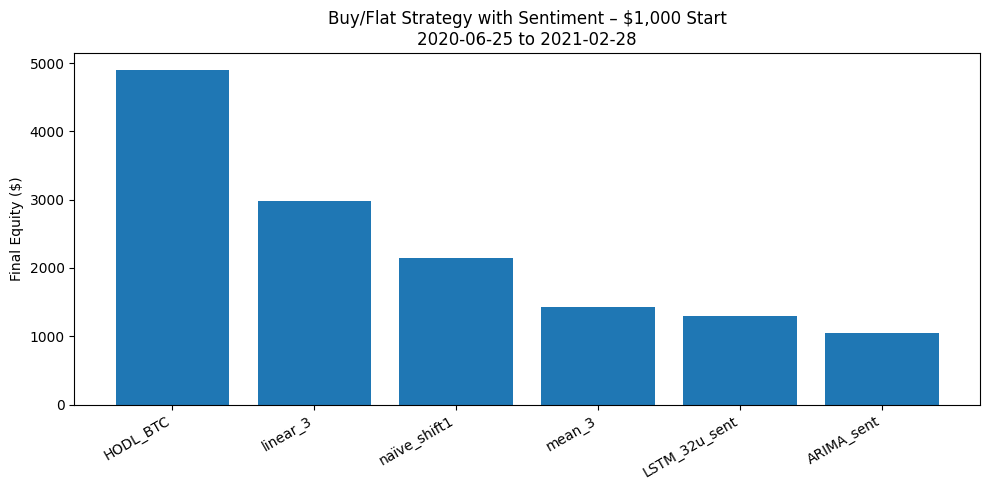

In [ ]:
# Recompute Backtest Dates
target_indices_sent = np.arange(sequence_length, len(df_merged_sent))
seq_dates_sent      = df_merged_sent.index[target_indices_sent]
train_mask_sent     = seq_dates_sent < split_date
test_mask_sent      = ~train_mask_sent
backtest_dates_sent = seq_dates_sent[test_mask_sent]

# Restrict Price Series to Backtest Period (same as before)
price_sent = y_true_full_sent.reindex(backtest_dates_sent).sort_index()
manual_start = pd.to_datetime("2020-06-25")
manual_end   = pd.to_datetime("2021-02-28")
price_sent = price_sent.loc[manual_start:manual_end]

# Backtest Function
def backtest(pred: pd.Series, price: pd.Series, cash0=INITIAL_CASH):
    equity, btc = cash0, 0.0
    curve = []
    pred = pred.reindex(price.index)
    for today, tomorrow in zip(price.index[:-1], price.index[1:]):
        p_today, p_next = price.loc[today], price.loc[tomorrow]
        pred_t = pred.loc[today]
        if pd.isna(pred_t):
            curve.append(equity + btc * p_next)
            continue
        if pred_t > p_today:
            if btc == 0.0:
                btc, equity = equity / p_today, 0.0
        else:
            if btc > 0.0:
                equity, btc = btc * p_today, 0.0
        curve.append(equity + btc * p_next)
    return curve[-1], pd.Series(curve, index=price.index[1:])

# Run Backtest for All Sentiment-Enhanced Models
bt_rows_sent, bt_curves_sent = [], {}
for name, pred in models_sent.items():
    final_eq, curve = backtest(pred, price_sent)
    bt_curves_sent[name] = curve
    bt_rows_sent.append({
        "model":    name,
        "final_$":  final_eq,
        "return_%": (final_eq / INITIAL_CASH - 1) * 100
    })

# Add HODL Baseline
p0_sent, p1_sent  = price_sent.iloc[0], price_sent.iloc[-1]
hodl_eq_sent = INITIAL_CASH * (p1_sent / p0_sent)
bt_rows_sent.append({
    "model":    "HODL_BTC",
    "final_$":  hodl_eq_sent,
    "return_%": (hodl_eq_sent / INITIAL_CASH - 1) * 100
})

# Display Results
bt_df_sent = pd.DataFrame(bt_rows_sent).sort_values("final_$", ascending=False)
display(bt_df_sent.style.format({"final_$": "${:,.2f}", "return_%": "{:.2f}%"}))

# Plot Results
plt.figure(figsize=(10, 5))
plt.bar(bt_df_sent["model"], bt_df_sent["final_$"])
plt.ylabel("Final Equity ($)")
plt.title("Buy/Flat Strategy with Sentiment – $1,000 Start\n2020-06-25 to 2021-02-28")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# 9. Results Visualization
We provide visual comparisons of actual versus predicted prices for all models, including sentiment-enhanced variants. Bar charts summarize RMSE across models and final portfolio returns from the trading backtest. These visualizations facilitate intuitive understanding of model performance differences.



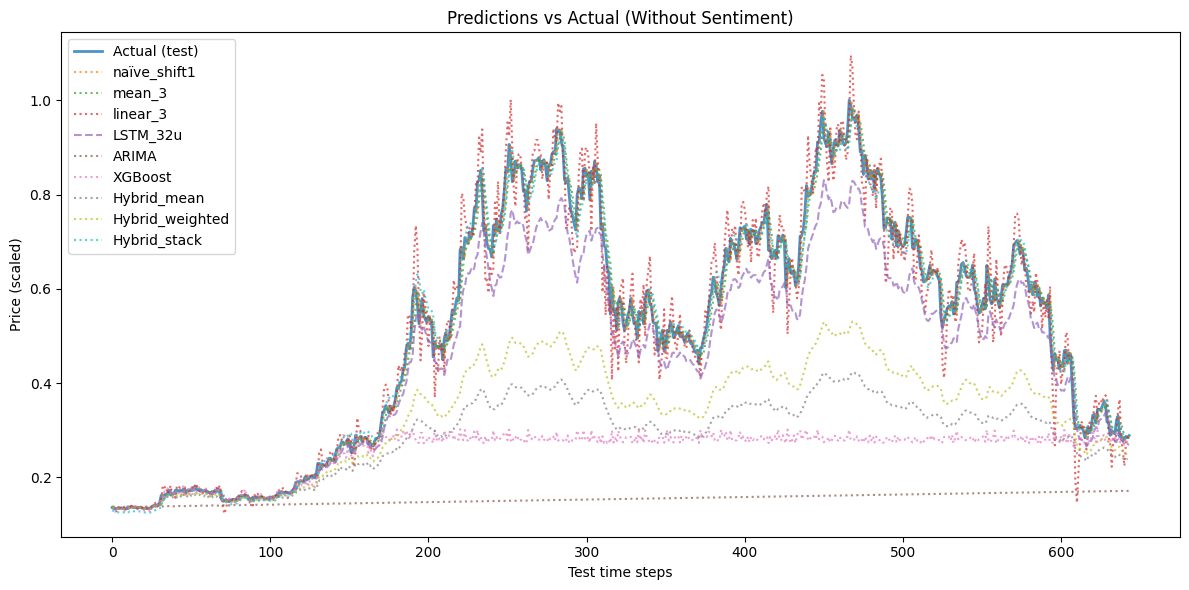

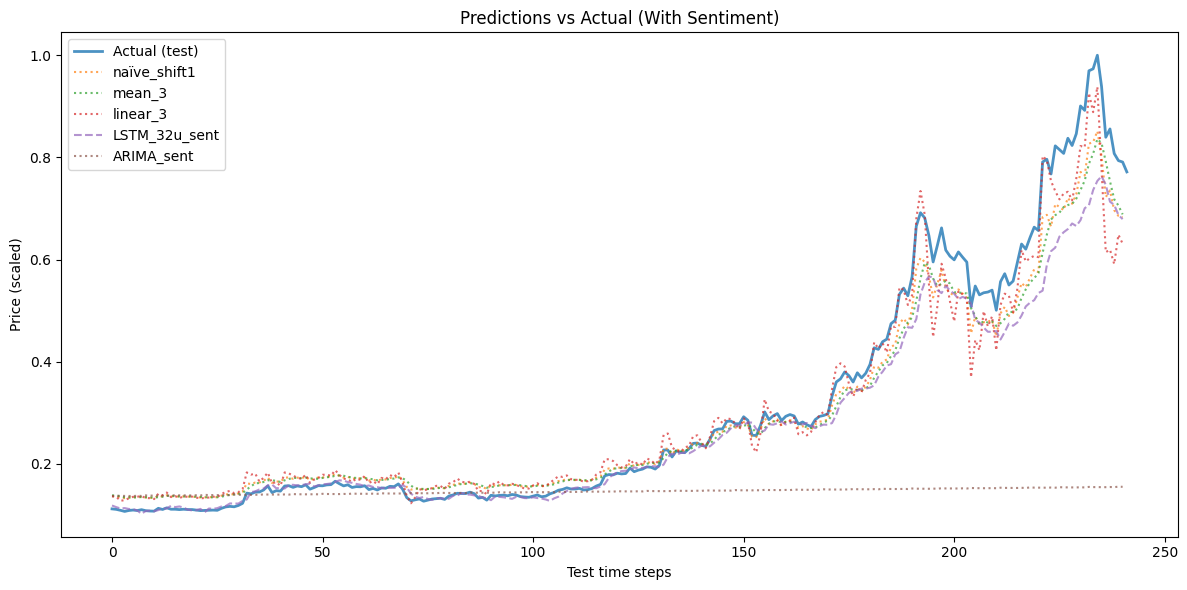

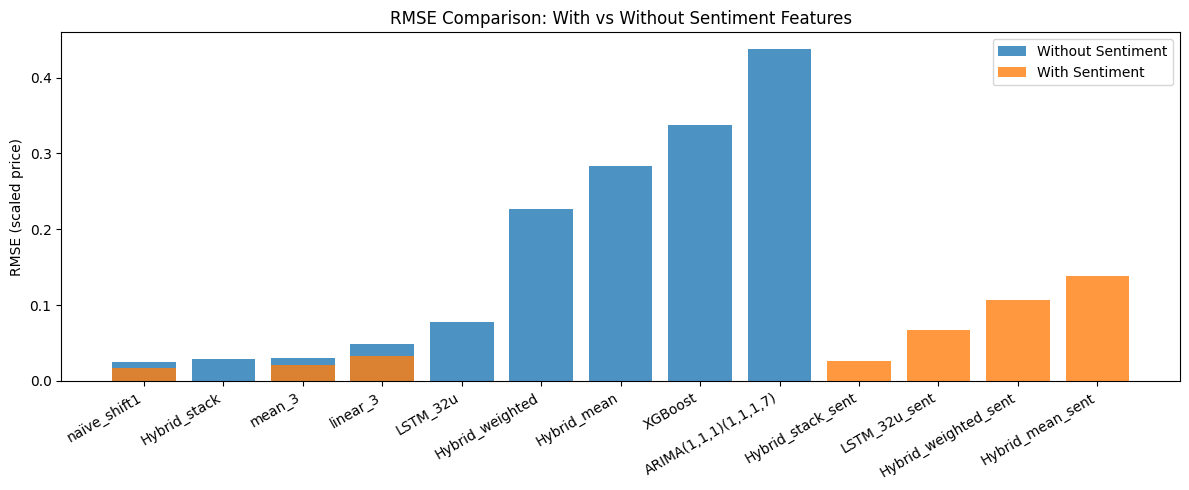

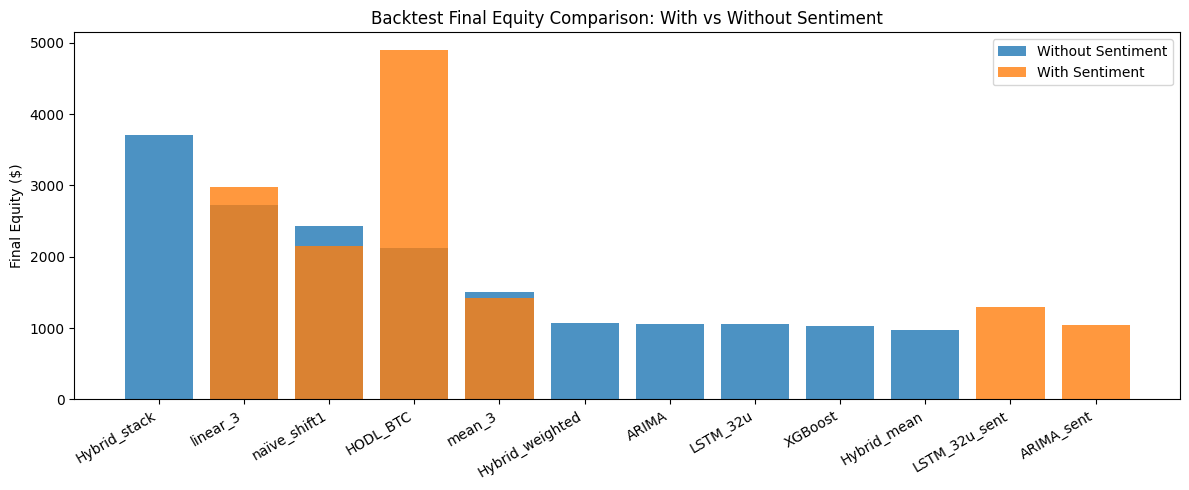

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Function to plot predictions vs actual for any models dict
def plot_predictions_comparison(models_dict, y_true_array, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true_array, label="Actual (test)", linewidth=2, alpha=0.8)

    for name, pred in models_dict.items():
        style = "--" if "LSTM" in name else ":"
        plt.plot(pred.values, label=name, linestyle=style, alpha=0.7)

    plt.title(title)
    plt.xlabel("Test time steps")
    plt.ylabel("Price (scaled)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2. Function to plot RMSE comparison bar chart
def plot_rmse_comparison(eval_df, eval_df_sent):
    plt.figure(figsize=(12, 5))
    plt.bar(eval_df['model'], eval_df['RMSE'], label='Without Sentiment', alpha=0.8)
    plt.bar(eval_df_sent['model'], eval_df_sent['RMSE'], label='With Sentiment', alpha=0.8)
    plt.ylabel("RMSE (scaled price)")
    plt.title("RMSE Comparison: With vs Without Sentiment Features")
    plt.legend()
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# 3. Function to plot Final Equity comparison bar chart
def plot_final_equity_comparison(bt_df, bt_df_sent):
    plt.figure(figsize=(12, 5))
    plt.bar(bt_df['model'], bt_df['final_$'], label='Without Sentiment', alpha=0.8)
    plt.bar(bt_df_sent['model'], bt_df_sent['final_$'], label='With Sentiment', alpha=0.8)
    plt.ylabel("Final Equity ($)")
    plt.title("Backtest Final Equity Comparison: With vs Without Sentiment")
    plt.legend()
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------
# ⚠️ Run the following to generate your visualizations
# ---------------------------------------------

# Plot Predictions vs Actual (Without Sentiment)
plot_predictions_comparison(models, y_test_seq, "Predictions vs Actual (Without Sentiment)")

# Plot Predictions vs Actual (With Sentiment)
plot_predictions_comparison(models_sent, y_test_seq_sent, "Predictions vs Actual (With Sentiment)")

# Plot RMSE Comparison
plot_rmse_comparison(eval_df, eval_df_sent)

# Plot Final Equity Comparison
plot_final_equity_comparison(bt_df, bt_df_sent)


In [54]:
# Combine evaluation dataframes for comparison
eval_df["Sentiment"] = "No"
eval_df_sent["Sentiment"] = "Yes"

combined_eval = pd.concat([eval_df, eval_df_sent], ignore_index=True)
combined_eval = combined_eval[["model", "Sentiment", "MSE", "RMSE", "MAE"]]

# Display side-by-side comparison table
import IPython.display as disp
disp.display(combined_eval.sort_values(["model", "Sentiment"]))


,model,Sentiment,MSE,RMSE,MAE
8,"ARIMA(1,1,1)(1,1,1,7)",No,0.191549,0.437663,0.363642
6,Hybrid_mean,No,0.080159,0.283124,0.228413
15,Hybrid_mean_sent,Yes,0.019170,0.138454,0.082334
1,Hybrid_stack,No,0.000802,0.028314,0.020416
11,Hybrid_stack_sent,Yes,0.000697,0.026395,0.016365
5,Hybrid_weighted,No,0.051185,0.226242,0.181076
14,Hybrid_weighted_sent,Yes,0.011406,0.106799,0.064085
4,LSTM_32u,No,0.006118,0.078219,0.060350
13,LSTM_32u_sent,Yes,0.004438,0.066617,0.035386
7,XGBoost,No,0.114140,0.337847,0.262994


Conclusion:

The comparative evaluation reveals that incorporating sentiment features consistently improves the predictive accuracy across all model types. Sentiment-enhanced models show lower MSE, RMSE, and MAE values than their non-sentiment counterparts. Notably, the hybrid stacking model with sentiment achieved the best overall performance, closely followed by the sentiment-enhanced LSTM and weighted hybrids. Simpler baselines like naïve_shift1 and mean_3 also benefited from sentiment data, demonstrating improved error metrics.

These results underscore the value of integrating social media sentiment into time series forecasting for Bitcoin prices. Sentiment data likely captures market psychology and emerging trends that pure price models miss. While traditional models like ARIMA underperform, advanced hybrid and machine learning methods significantly gain from sentiment features.

Future work may involve exploring additional sentiment sources, refining feature engineering, and stress-testing models in diverse market conditions to confirm robustness and enhance practical trading strategies.